# Regression prediction of continuous variable, as opposed to classification prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


In [2]:
# Get the automobile MPG data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the dataset

In [3]:
# Drop null rows
dataset = dataset.dropna()

# Origin is actually categorical not numeric so convert to one-hot encoding
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='') # <- coverts a categorical columm to one-hot dummy variables

# Split into train/test
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)

print(train.size)
print(test.size)

3140
780


## Inspect the Data

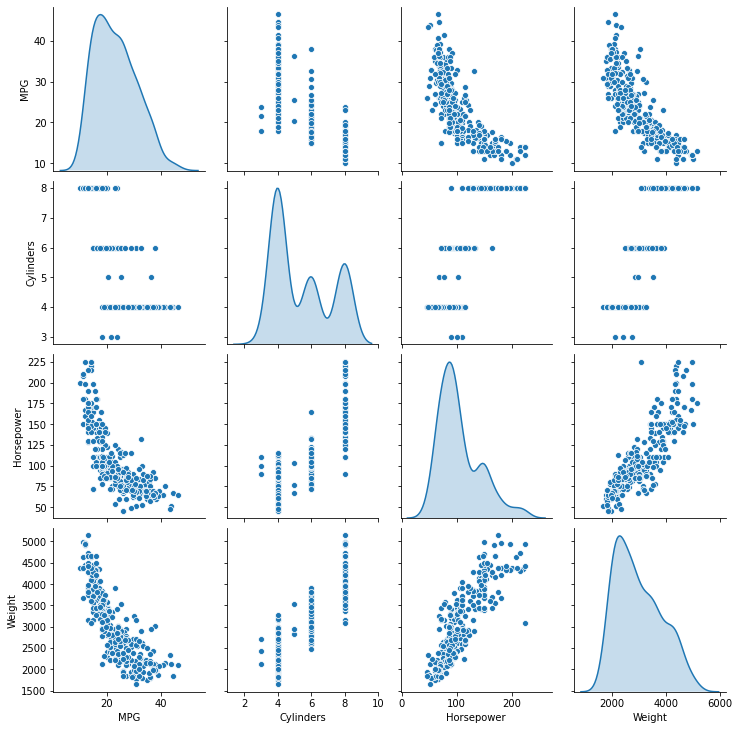

In [4]:
# Joint distributions of pairs of data, using seaborn
sns.pairplot(train[['MPG', 'Cylinders', 'Horsepower', 'Weight']], diag_kind='kde')

In [5]:
# View train statistics
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


# Preprocessing

In [6]:
# Split features from labels, the "label" is the thing we want to predict, in this case MPG
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [7]:
# Normalisation - We can see from the stats above that the range for each variable is quite different so we shoul dnormalise to 1
normaliser = preprocessing.Normalization()
normaliser.adapt(np.array(train_features))

# Stores the data and then when called returns its normlised version
first = np.array(train_features[:1])
print(f'Example NonNormed: {first} \n')
print(f'Example Normed: {normaliser(first).numpy()}')

Example NonNormed: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]] 

Example Normed: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517 -0.466 -0.496  0.776]]


# Build a normal liner regression model first for comparison, using horsepower only

In [8]:
hp = np.array(train_features['Horsepower'])
hp_norm = preprocessing.Normalization(input_shape=[1,])
hp_norm.adapt(hp)

hp_model = tf.keras.Sequential([
    hp_norm,
    layers.Dense(units=1)
])

hp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

hp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [9]:
%%time
history = hp_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0, # <= Suppress logging
    validation_split=0.2
)

CPU times: user 2.11 s, sys: 253 ms, total: 2.37 s
Wall time: 1.85 s


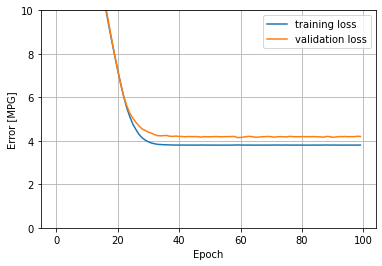

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

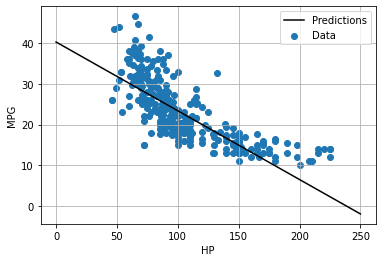

In [11]:
# Collect test results for comparison later and plot against the input variable
test_res = {}
test_res['hp_model'] = hp_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = hp_model.predict(x)

def plot_hp(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('HP')
    plt.ylabel('MPG')
    plt.legend()
    plt.grid(True)
    
plot_hp(x,y)

## We can extend this to multivariate linear regression easily by inputting a vector as opposed to a single variable

CPU times: user 2.05 s, sys: 225 ms, total: 2.28 s
Wall time: 1.79 s


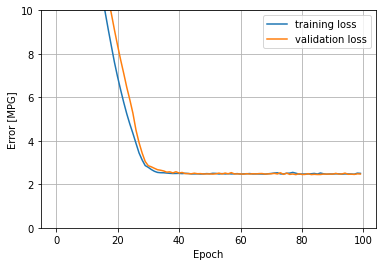

In [14]:
%%time
mv_model = tf.keras.Sequential([
    normaliser,
    layers.Dense(units=1)
])

mv_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history_mv = mv_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=0,
    validation_split = 0.2)

plot_loss(history_mv)

In [15]:
test_res['mv_model'] = mv_model.evaluate(test_features, test_labels, verbose=0)

# Predicting with a Dense NN

In [16]:
# Single variable and multi variable NN will use the same modelling procedure so define it as a fn
def build_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

In [17]:
# Single var
dnn_hp_model = build_compile_model(hp_norm)
dnn_hp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


CPU times: user 2.79 s, sys: 732 ms, total: 3.52 s
Wall time: 2.26 s


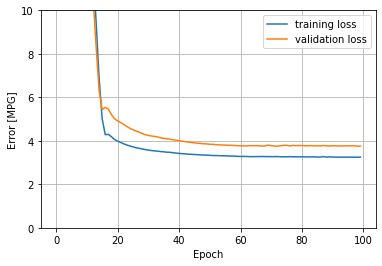

In [18]:
%%time 
history_dnn_hp = dnn_hp_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

plot_loss(history_dnn_hp)

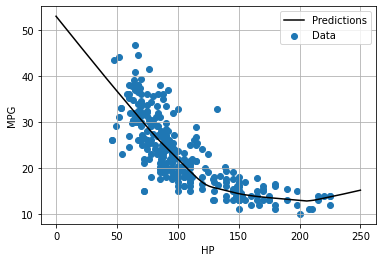

In [20]:
# If we plot the 1:1 HP:MPG relationship we can see the nonlinearity of the dense NN coming into effect
x = tf.linspace(0, 250, 251)
y = dnn_hp_model.predict(x)

test_res['dnn_hp_model'] = dnn_hp_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)

plot_hp(x, y)

## Full Model

In [21]:
dnn_model = build_compile_model(normaliser)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


CPU times: user 2.39 s, sys: 751 ms, total: 3.14 s
Wall time: 1.87 s


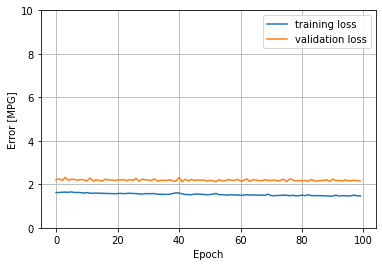

In [23]:
%%time
history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

test_res['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

plot_loss(history_dnn)

In [25]:
df = pd.DataFrame(test_res, index=['Mean Absolute Error (MPG)']).T
df

,Mean Absolute Error (MPG)
hp_model,3.644471
mv_model,2.438353
dnn_hp_model,2.882184
dnn_model,1.699112


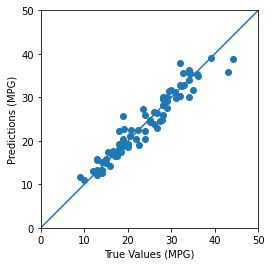

In [27]:
# Make Predictions
test_pred = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values (MPG)')
plt.ylabel('Predictions (MPG)')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Predictions look reasonable

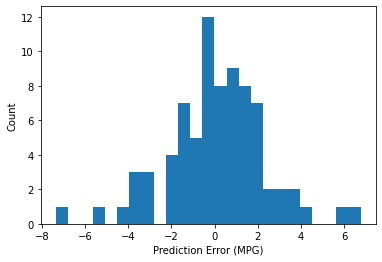

In [28]:
error = test_pred - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error (MPG)')
_ = plt.ylabel('Count')